# Mark's Notebook

## Imports

In [73]:
import cv2
import numpy as np
import os
import math
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scripts.utils import *
from scripts.edges import *

## Loading an image to work with

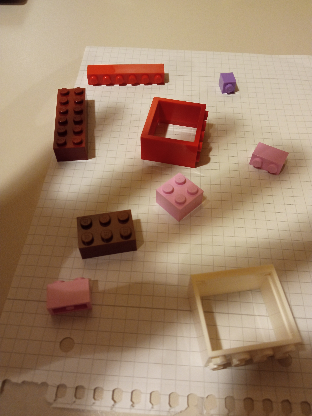

In [74]:
img = loadImage(19)

render(img)

## Investigation

In [75]:
""" # Get the histogram of the image

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Calculate the histogram
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

# Plot the histogram
plt.plot(hist)
plt.xlim([0, 256])
plt.show()

render(gray)
 """;

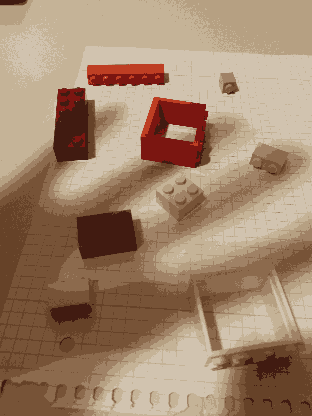

In [76]:
# Apply k-means clustering to segment the image

blurred = cv2.GaussianBlur(img, (3, 3), 0)

# Convert the image to a 2D array of pixels
pixels = img.reshape((-1, 3))
pixels = np.float32(pixels)

# Define the criteria, number of clusters and apply k-means
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1.0)
num_clusters = 10 # Adjust based on the number of colors you want
_, labels, centers = cv2.kmeans(pixels, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back to 8 bit values
centers = np.uint8(centers)

# Map the labels to the centers
segmented_data = centers[labels.flatten()]

# Reshape the data into the original image
segmented_image = segmented_data.reshape((img.shape))

render(segmented_image)

In [77]:
""" # Smooth the image using Gaussian blur
blurred = cv2.GaussianBlur(img, (23, 23), 0)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)

# Reshape the image into a 2D array of pixels
pixels = image_rgb.reshape((-1, 3))

# Use KMeans to perform color quantization
kmeans = KMeans(n_clusters=10)  # Adjust the number of clusters as needed
kmeans.fit(pixels)

# Get the cluster centers and labels
colors = kmeans.cluster_centers_
labels = kmeans.labels_

# Get the counts of each label
label_counts = np.bincount(labels)

# Get the index of the most common color (excluding background)
background_label = np.argmax(label_counts)
common_color_index = np.argmax(np.delete(label_counts, background_label))

# Get the most common color
common_color = colors[common_color_index].astype(int)

# Threshold to separate background and foreground
threshold = 30  # Adjust as needed
background_mask = np.all(np.abs(colors - common_color) < threshold, axis=1)

# Remove background pixels
masked_labels = labels.reshape(image_rgb.shape[:2])
masked_labels[background_mask[masked_labels]] = background_label
image_rgb[masked_labels == background_label] = [0, 0, 0]  # Set background pixels to black

render(image_rgb) """;

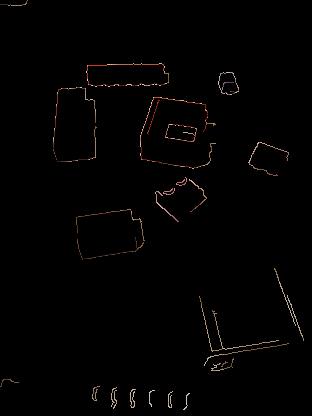

In [78]:
# Use the Canny edge detector to detect edges

# Convert the image to grayscale
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 100, 200)

# Create a mask for the edges
edge_mask = np.zeros_like(img)

# Set the edge pixels to white
edge_mask[edges > 0] = (255, 255, 255)

# Apply the mask to the original image
edge_image = cv2.bitwise_and(img, edge_mask)

render(edge_image)

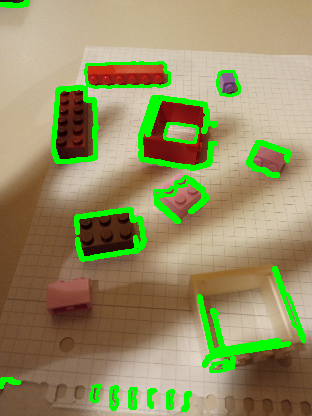

In [79]:
# Find contours in the edge image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a kernel for dilation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Adjust kernel size as needed

# Dilate the edge image
dilated_edges = cv2.dilate(edges, kernel)

# Find contours in the dilated image
contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on a copy of the original image
contour_image = img.copy()

cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Display or save the resulting image
render(contour_image)

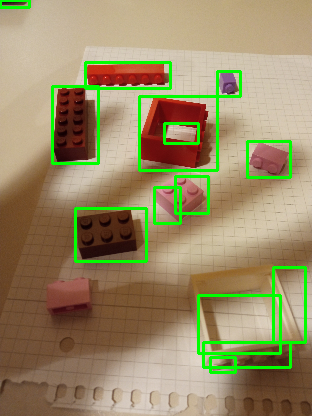

Number of Lego pieces: 14


In [80]:
num_legos = 0

# Define area threshold for bounding rectangles
area_threshold = 200  # Adjust as needed
intersection_threshold = 0.25

# Create a copy of the original image for drawing bounding boxes
bounding_box_image = img.copy()

# List to store bounding rectangles of drawn legos
bounding_rectangles = []

# Iterate through contours
for contour in contours:
    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate the area of the bounding rectangle
    area = w * h
    
    # Check if area is above the threshold
    if area > area_threshold:
        # Check if this bounding rectangle overlaps with any previously drawn ones
        overlap = False
        contained = False
        for (bx, by, bw, bh) in bounding_rectangles:
            intersection_area = max(0, min(x+w, bx+bw) - max(x, bx)) * max(0, min(y+h, by+bh) - max(y, by))
            union_area = area + bw*bh - intersection_area
            if intersection_area / union_area > intersection_threshold:
                overlap = True
                # print("OVERLAP")
                break
            if x >= bx and y >= by and x + w <= bx + bw and y + h <= by + bh:
                contained = True
                # print("CONTAINED")
                break
        
        # If not fully contained and no significant overlap, draw the bounding box and increment lego count
        if not contained and not overlap:
            cv2.rectangle(bounding_box_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            bounding_rectangles.append((x, y, w, h))
            num_legos += 1
        
# Display the image with bounding boxes
render(bounding_box_image)

# Print the number of legos
print("Number of Lego pieces:", num_legos)
